# Testing HDX Burn


In [1]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import random

# Experiments
from model import run
from model import processing
#from model.plot_utils import *
from model import plot_utils as pu
from model import init_utils
from model.amm import omnipool_amm as oamm



########## AGENT CONFIGURATION ##########
# key -> token name, value -> token amount owned by agent
# note that token name of 'omniABC' is used for omnipool LP shares of token 'ABC'
# omniHDXABC is HDX shares dedicated to pool of token ABC
LP1 = {'omniR1': 500000}
LP2 = {'omniR2': 1500000}
trader = {'HDX': 1000000, 'R1': 1000000, 'R2': 1000000}

# key -> agent_id, value -> agent dict
agent_d = {'Trader': trader, 'LP1': LP1, 'LP2': LP2}


########## ACTION CONFIGURATION ##########

action_dict = {
    'sell_hdx_for_r1': {'token_buy': 'R1', 'token_sell': 'HDX', 'amount_sell': 2000, 'action_id': 'Trade', 'agent_id': 'Trader'},
    'sell_r1_for_hdx': {'token_sell': 'R1', 'token_buy': 'HDX', 'amount_sell': 1000, 'action_id': 'Trade', 'agent_id': 'Trader'}
}

# list of (action, number of repititions of action), timesteps = sum of repititions of all actions
trade_count = 1
action_ls = [('trade', trade_count)]

# maps action_id to action dict, with some probability to enable randomness
prob_dict = {
    'trade': {'sell_hdx_for_r1': 0.5,
              'sell_r1_for_hdx': 0.5}
}



########## CFMM INITIALIZATION ##########
blocks_per_day = 5 * 60 * 24  # 12-second blocks
r = 0.1
initial_values = {
    'token_list': ['R1','R2'],
    'R': [500000,1500000],
    'P': [2,2/3],
    'H': 20000000000,
    'T': 15000000000,
    'burn_rate': (1 + r)**(1/blocks_per_day) - 1,  # r% per day: (1 + x)^blocks_per_day = 1 + r -> (1 + r)^(1/blocks_per_day) - 1 = x
    'fee_assets': 0,
    'fee_HDX': 0
}


initial_list = []
config_params = {
    'cfmm_type': "",
    'initial_values': initial_values,
    'agent_d': agent_d,
    'action_ls': action_ls,
    'prob_dict': prob_dict,
    'action_dict': action_dict,
}

config_dict, state = init_utils.get_configuration(config_params)

pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.float_format = '{:.2f}'.format

run.config(config_dict, state)
events = run.run()



                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (1, 3, 1, 3)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 0.01s


In [2]:
# add prices
def add_price_list_to_state(d: dict) -> None:
    d['AMM']['P'] = [oamm.price_i(d['AMM'], i) for i in range(len(d['AMM']['R']))]
    return d
events = list(map(add_price_list_to_state, events))
rdf, agent_df = processing.postprocessing(events)


In [3]:
%matplotlib inline



In [4]:
rdf.tail(20)

,R-0,R-1,Q-0,Q-1,S-0,S-1,A-0,A-1,B-0,B-1,...,fee_HDX,burn_rate,P-0,P-1,n,simulation,subset,run,substep,timestep
0,500000,1500000,1000000.00,1000000.00,500000,1500000,0,0,0,0,...,0,0.00,2.00,0.67,2,0,0,1,0,0
3,501000,1500000,998017.20,1000013.24,500000,1500000,0,0,0,0,...,0,0.00,1.99,0.67,2,0,0,1,3,1


## Analysis

[0]


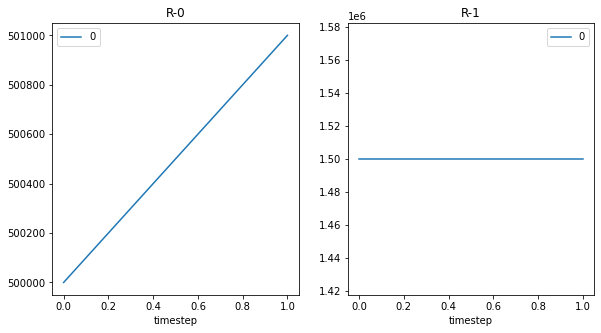

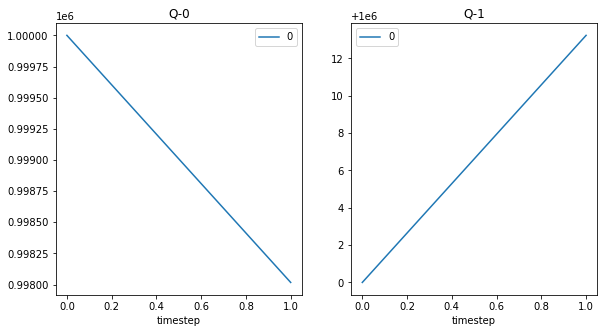

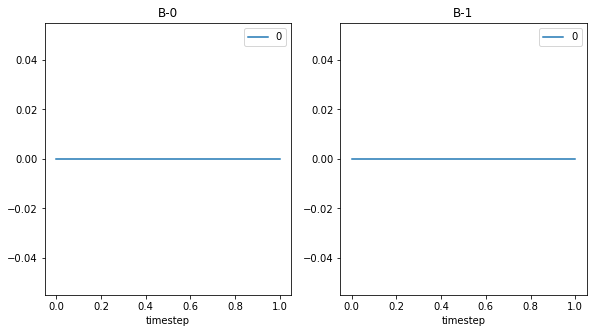

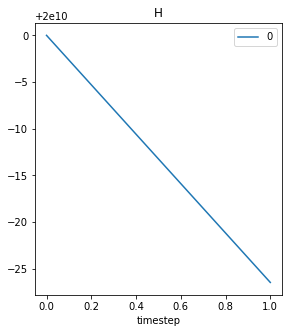

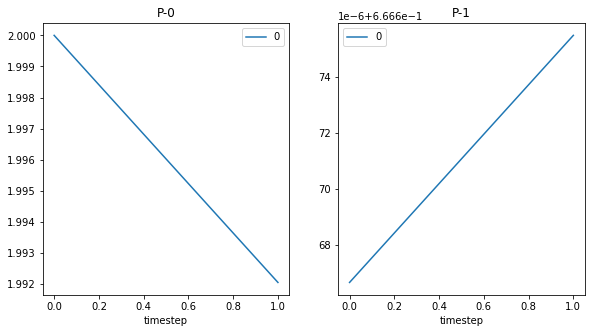

In [5]:
var_list = ['R', 'Q', 'B', 'H', 'P']
pu.plot_vars(rdf, var_list)


[0]


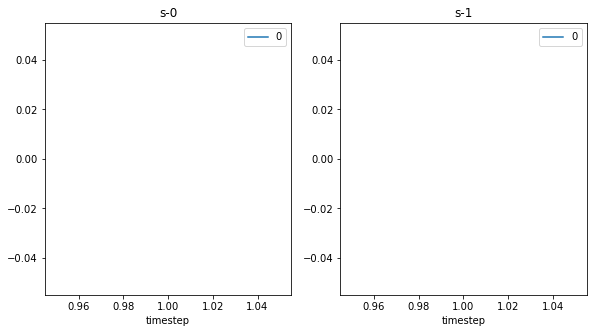

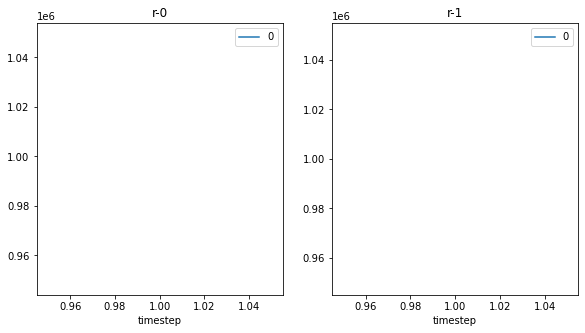

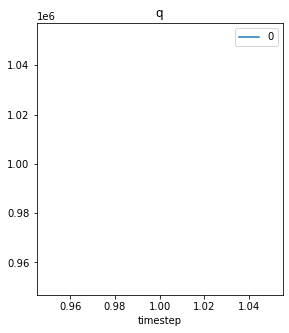

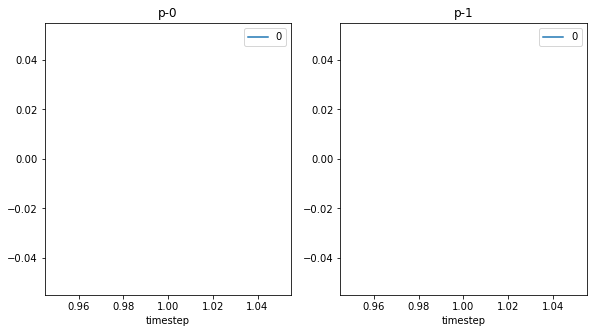

In [6]:
var_list = ['s', 'r', 'q', 'p']
trader_df = agent_df[agent_df['agent_label'] == 'Trader']
pu.plot_vars(trader_df, var_list)


In [7]:
# add price column

## Conclusion

